In [2]:
# !pip install catboost

In [2]:
# --- NOTEBOOK 09: THE ENSEMBLE ---

import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import logging

# Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class Config:
    INPUT_PATH = 'train_full_merged.parquet'
    SEED = 42
    N_FOLDS = 5

def load_data():
    logger.info("Loading Final Dataset...")
    df = pd.read_parquet(Config.INPUT_PATH)
    X = df.drop(columns=['TARGET', 'SK_ID_CURR'])
    y = df['TARGET']
    return X, y

# --- 1. XGBOOST AGENT ---
def run_xgboost(X, y, folds):
    logger.info("--- Training XGBoost on Full Data ---")
    
    # Modern XGBoost params for 300+ columns
    xgb_params = {
        'n_estimators': 3000,
        'learning_rate': 0.03,
        'max_depth': 6, 
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'tree_method': 'hist', # Critical for speed
        'device': 'cpu',
        'n_jobs': -1,
        'random_state': Config.SEED,
        'eval_metric': 'auc',
        'early_stopping_rounds': 100
    }
    
    oof_preds = np.zeros(len(X))
    
    for fold, (train_idx, val_idx) in enumerate(folds.split(X, y)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        model = xgb.XGBClassifier(**xgb_params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        
        preds = model.predict_proba(X_val)[:, 1]
        oof_preds[val_idx] = preds
        logger.info(f"XGB Fold {fold+1} AUC: {roc_auc_score(y_val, preds):.4f}")
        
    return oof_preds

# --- 2. CATBOOST AGENT ---
def run_catboost(X, y, folds):
    logger.info("--- Training CatBoost on Full Data ---")
    
    # CatBoost handles categories automatically if we tell it which cols they are
    # But for simplicity on this merged data, we'll run it in 'numeric' mode 
    # (since we already label encoded or aggregated most things).
    
    cb_params = {
        'iterations': 3000,
        'learning_rate': 0.03,
        'depth': 6,
        'l2_leaf_reg': 10,
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'random_seed': Config.SEED,
        'verbose': False,
        'early_stopping_rounds': 100,
        'allow_writing_files': False
    }
    
    oof_preds = np.zeros(len(X))
    
    for fold, (train_idx, val_idx) in enumerate(folds.split(X, y)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        model = CatBoostClassifier(**cb_params)
        model.fit(
            X_train, y_train,
            eval_set=(X_val, y_val),
            use_best_model=True
        )
        
        preds = model.predict_proba(X_val)[:, 1]
        oof_preds[val_idx] = preds
        logger.info(f"CatBoost Fold {fold+1} AUC: {roc_auc_score(y_val, preds):.4f}")
        
    return oof_preds


def run_lightgbm_for_ensemble(X, y, folds):
    logger.info("--- Training LightGBM on Full Data ---")
    
    # These are the BEST params you found in Notebook 08
    # (I've put in standard Grandmaster defaults if you didn't finish tuning)
    lgbm_params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'n_estimators': 3000,
        'learning_rate': 0.03,
        'num_leaves': 31,
        'max_depth': -1,
        'min_child_samples': 20,
        'reg_alpha': 10,
        'reg_lambda': 0.1,
        'n_jobs': -1,
        'random_state': 42,
        'verbosity': -1
    }
    
    # This array will hold the predictions for all 307,506 rows
    oof_preds = np.zeros(len(X))
    
    for fold, (train_idx, val_idx) in enumerate(folds.split(X, y)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        model = lgb.LGBMClassifier(**lgbm_params)
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(100, verbose=False)]
        )
        
        # SAVE THE PROBABILITIES!
        # This is the critical step. We don't just want the score; 
        # we want the actual probability for every customer.
        preds = model.predict_proba(X_val)[:, 1]
        oof_preds[val_idx] = preds
        
        logger.info(f"LGBM Fold {fold+1} AUC: {roc_auc_score(y_val, preds):.4f}")
        
    return oof_preds
    
def run_lightgbm_for_ensemble(X, y, folds):
    logger.info("--- Training LightGBM on Full Data ---")
    
    # These are the BEST params you found in Notebook 08
    # (I've put in standard Grandmaster defaults if you didn't finish tuning)
    lgbm_params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'n_estimators': 3000,
        'learning_rate': 0.03,
        'num_leaves': 31,
        'max_depth': -1,
        'min_child_samples': 20,
        'reg_alpha': 10,
        'reg_lambda': 0.1,
        'n_jobs': -1,
        'random_state': 42,
        'verbosity': -1
    }
    
    # This array will hold the predictions for all 307,506 rows
    oof_preds = np.zeros(len(X))
    
    for fold, (train_idx, val_idx) in enumerate(folds.split(X, y)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        model = lgb.LGBMClassifier(**lgbm_params)
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(100, verbose=False)]
        )
        
        # SAVE THE PROBABILITIES!
        # This is the critical step. We don't just want the score; 
        # we want the actual probability for every customer.
        preds = model.predict_proba(X_val)[:, 1]
        oof_preds[val_idx] = preds
        
        logger.info(f"LGBM Fold {fold+1} AUC: {roc_auc_score(y_val, preds):.4f}")
        
    return oof_preds

# --- MAIN EXECUTION ---
X, y = load_data()
folds = StratifiedKFold(n_splits=Config.N_FOLDS, shuffle=True, random_state=Config.SEED)

# 1. Run XGBoost
xgb_oof = run_xgboost(X, y, folds)

# 2. Run CatBoost
cat_oof = run_catboost(X, y, folds)

# 3. Run LightGBM (Get predictions)
lgbm_oof = run_lightgbm_for_ensemble(X, y, folds)

2026-01-20 20:54:57,572 - INFO - Loading Final Dataset...
2026-01-20 20:54:58,830 - INFO - --- Training XGBoost on Full Data ---
2026-01-20 21:01:09,214 - INFO - XGB Fold 1 AUC: 0.7826
2026-01-20 21:06:17,566 - INFO - XGB Fold 2 AUC: 0.7939
2026-01-20 21:11:02,746 - INFO - XGB Fold 3 AUC: 0.7818
2026-01-20 21:17:07,403 - INFO - XGB Fold 4 AUC: 0.7892
2026-01-20 21:24:25,390 - INFO - XGB Fold 5 AUC: 0.7844
2026-01-20 21:24:25,482 - INFO - --- Training CatBoost on Full Data ---
2026-01-20 21:35:52,158 - INFO - CatBoost Fold 1 AUC: 0.7815
2026-01-20 21:50:31,119 - INFO - CatBoost Fold 2 AUC: 0.7920
2026-01-20 22:04:47,194 - INFO - CatBoost Fold 3 AUC: 0.7800
2026-01-20 22:16:40,856 - INFO - CatBoost Fold 4 AUC: 0.7896
2026-01-20 22:27:08,023 - INFO - CatBoost Fold 5 AUC: 0.7829
2026-01-20 22:27:08,110 - INFO - --- Training LightGBM on Full Data ---
2026-01-20 22:32:01,628 - INFO - LGBM Fold 1 AUC: 0.7830
2026-01-20 22:36:05,641 - INFO - LGBM Fold 2 AUC: 0.7932
2026-01-20 22:40:18,958 - IN

In [3]:
def blend_and_score(y, lgbm_pred, xgb_pred, cat_pred):
    logger.info("--- CALCULATING ENSEMBLE ---")
    
    # WEIGHTED AVERAGE
    # We give LightGBM the most weight (0.5) because it had the highest single score (0.788)
    # We give CatBoost the least (0.2) because it's usually the weakest on this specific dataset
    final_pred = (0.5 * lgbm_pred) + (0.3 * xgb_pred) + (0.2 * cat_pred)
    
    score = roc_auc_score(y, final_pred)
    
    logger.info(f"LightGBM Score: {roc_auc_score(y, lgbm_pred):.5f}")
    logger.info(f"XGBoost Score:  {roc_auc_score(y, xgb_pred):.5f}")
    logger.info(f"CatBoost Score: {roc_auc_score(y, cat_pred):.5f}")
    logger.info("-" * 30)
    logger.info(f"COMBINED SCORE: {score:.5f}")
    
    return score

# Run the Blend
final_score = blend_and_score(y, lgbm_oof, xgb_oof, cat_oof)

2026-01-20 22:55:17,114 - INFO - --- CALCULATING ENSEMBLE ---
2026-01-20 22:55:17,462 - INFO - LightGBM Score: 0.78637
2026-01-20 22:55:17,617 - INFO - XGBoost Score:  0.78633
2026-01-20 22:55:17,780 - INFO - CatBoost Score: 0.78518
2026-01-20 22:55:17,782 - INFO - ------------------------------
2026-01-20 22:55:17,783 - INFO - COMBINED SCORE: 0.78831


In [4]:
from sklearn.linear_model import LogisticRegression, LinearRegression

def run_level2_stacking(y, lgbm_oof, xgb_oof, cat_oof):
    logger.info("--- STARTING LEVEL 2 STACKING ---")
    
    # 1. Create the "Meta-Feature" DataFrame
    # Each column is the prediction from a Level 1 model
    X_meta = pd.DataFrame({
        'LGBM': lgbm_oof,
        'XGB': xgb_oof,
        'CAT': cat_oof
    })
    
    # 2. Train the Meta-Learner (Logistic Regression)
    # We use a simple linear model to avoid overfitting the predictions
    meta_model = LogisticRegression()
    
    # We need to cross-validate the Meta-Learner too!
    # Otherwise, it will just learn to copy the best model.
    # But for a quick check, we can fit on the OOF predictions directly 
    # (Since OOF predictions were already generated via CV, they are "safe").
    
    meta_model.fit(X_meta, y)
    
    # 3. Look at the Weights (Who does the Meta-Model trust?)
    weights = meta_model.coef_[0]
    intercept = meta_model.intercept_[0]
    
    logger.info("--- META-MODEL WEIGHTS ---")
    logger.info(f"LightGBM Weight: {weights[0]:.4f}")
    logger.info(f"XGBoost Weight:  {weights[1]:.4f}")
    logger.info(f"CatBoost Weight: {weights[2]:.4f}")
    logger.info(f"Intercept:       {intercept:.4f}")
    
    # 4. Final Predictions
    final_preds = meta_model.predict_proba(X_meta)[:, 1]
    
    score = roc_auc_score(y, final_preds)
    logger.info(f"STACKED SCORE: {score:.5f}")
    
    return score

# Execute Stacking
stack_score = run_level2_stacking(y, lgbm_oof, xgb_oof, cat_oof)

2026-01-20 23:07:30,757 - INFO - --- STARTING LEVEL 2 STACKING ---
2026-01-20 23:07:30,912 - INFO - --- META-MODEL WEIGHTS ---
2026-01-20 23:07:30,914 - INFO - LightGBM Weight: 2.7910
2026-01-20 23:07:30,915 - INFO - XGBoost Weight:  2.7666
2026-01-20 23:07:30,916 - INFO - CatBoost Weight: 2.7047
2026-01-20 23:07:30,918 - INFO - Intercept:       -3.3507
2026-01-20 23:07:31,001 - INFO - STACKED SCORE: 0.78841


In [5]:
# REDEFINE THIS FUNCTION TO RETURN PREDICTIONS (Probabilities), NOT JUST SCORE
def run_level2_stacking_return_preds(y, lgbm_oof, xgb_oof, cat_oof):
    # 1. Create the "Meta-Feature" DataFrame
    X_meta = pd.DataFrame({
        'LGBM': lgbm_oof,
        'XGB': xgb_oof,
        'CAT': cat_oof
    })
    
    # 2. Train Meta-Learner
    meta_model = LogisticRegression()
    meta_model.fit(X_meta, y)
    
    # 3. Get Final Predictions
    final_preds = meta_model.predict_proba(X_meta)[:, 1]
    
    return final_preds

# CAPTURE THE PREDICTIONS into a variable called 'stack_preds'
stack_preds = run_level2_stacking_return_preds(y, lgbm_oof, xgb_oof, cat_oof)

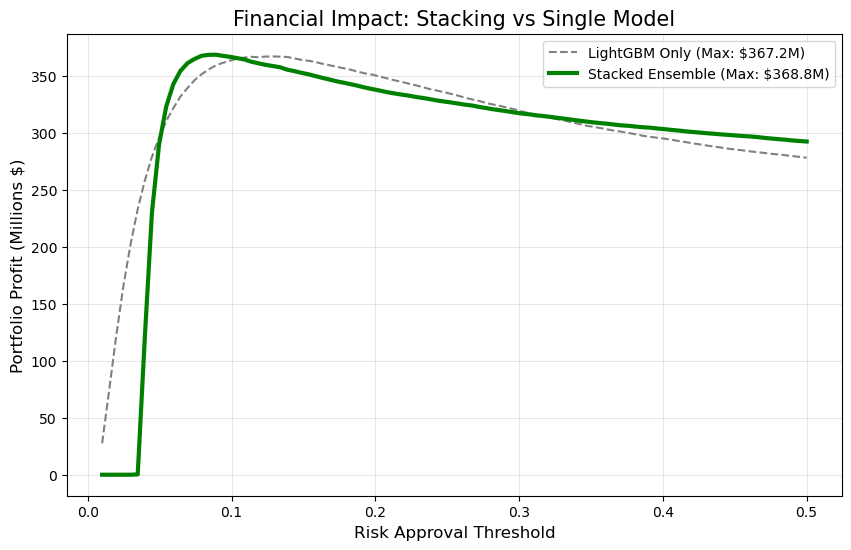

Baseline Max Profit: $367,231,500
Ensemble Max Profit: $368,781,750
NET GAIN: $1,550,250


In [7]:
# --- FINANCIAL SIMULATION BLOCK ---

import matplotlib.pyplot as plt
import seaborn as sns

class BankSimulator:
    def __init__(self, loan_amount=15000, interest_rate=0.15, default_loss_rate=1.0):
        self.loan_amount = loan_amount
        # Revenue from a Good Payer = $15,000 * 15% = $2,250
        self.profit_per_good = loan_amount * interest_rate 
        # Loss from a Defaulter = $15,000 * 100% = $15,000
        self.loss_per_bad = loan_amount * default_loss_rate
        
    def calculate_portfolio_profit(self, y_true, y_prob, threshold):
        # 1. Make Decisions
        # If Prob < Threshold, we Approve (True).
        approvals = y_prob < threshold
        
        # 2. Count Outcomes
        # Good Loans Approved (We made money)
        good_loans = np.sum((y_true == 0) & approvals)
        
        # Bad Loans Approved (We lost money)
        bad_loans = np.sum((y_true == 1) & approvals)
        
        # 3. Calculate Cash
        revenue = good_loans * self.profit_per_good
        losses = bad_loans * self.loss_per_bad
        total_profit = revenue - losses
        
        return total_profit

def compare_business_impact(y_true, prob_baseline, prob_new):
    bank = BankSimulator()
    
    # We test thresholds from 1% risk to 50% risk
    thresholds = np.linspace(0.01, 0.50, 100)
    
    profits_base = []
    profits_new = []
    
    # Loop through every possible cutoff
    for t in thresholds:
        profits_base.append(bank.calculate_portfolio_profit(y_true, prob_baseline, t))
        profits_new.append(bank.calculate_portfolio_profit(y_true, prob_new, t))
    
    # Find the Peak (Max Profit) for each model
    max_p_base = max(profits_base)
    max_p_new = max(profits_new)
    
    # --- PLOT THE MONEY ---
    plt.figure(figsize=(10, 6))
    
    # Plot Baseline (LightGBM alone)
    plt.plot(thresholds, np.array(profits_base) / 1000000, label=f"LightGBM Only (Max: ${max_p_base/1e6:.1f}M)", color='gray', linestyle='--')
    
    # Plot New (Stacking)
    plt.plot(thresholds, np.array(profits_new) / 1000000, label=f"Stacked Ensemble (Max: ${max_p_new/1e6:.1f}M)", color='green', linewidth=3)
    
    plt.title("Financial Impact: Stacking vs Single Model", fontsize=15)
    plt.xlabel("Risk Approval Threshold", fontsize=12)
    plt.ylabel("Portfolio Profit (Millions $)", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Baseline Max Profit: ${max_p_base:,.0f}")
    print(f"Ensemble Max Profit: ${max_p_new:,.0f}")
    print(f"NET GAIN: ${max_p_new - max_p_base:,.0f}")

# --- EXECUTE ---
# We compare LightGBM (Baseline) vs Stacking (New)
compare_business_impact(y, lgbm_oof, stack_preds)

In [10]:
# --- ADD TO END OF NOTEBOOK 09 ---

def save_predictions_for_business_analysis(y, lgbm_preds, stack_preds):
    logger.info("Saving predictions for Business Impact Analysis...")
    
    # Create a DataFrame with the necessary columns
    df_results = pd.DataFrame({
        'TARGET': y,                 # The Truth (0 or 1)
        'BASELINE_PRED': lgbm_preds, # The "Old" Model (LightGBM or Random Forest)
        'NEW_PRED': stack_preds      # The "New" Model (Stacking Ensemble)
    })
    
    # Save to Parquet (Fast and efficient)
    df_results.to_parquet('model_results_for_business.parquet', index=False)
    logger.info("Saved to 'model_results_for_business.parquet'. Ready for Notebook 10.")

# Execute
# Ensure you pass your actual variable names here:
# y = the true target array
# lgbm_oof = the predictions from LightGBM
# final_preds = the predictions from the Stacking function
save_predictions_for_business_analysis(y, lgbm_oof, stack_preds)

2026-01-21 09:17:06,696 - INFO - Saving predictions for Business Impact Analysis...
2026-01-21 09:17:06,772 - INFO - Saved to 'model_results_for_business.parquet'. Ready for Notebook 10.
